# Mobile Phone Price Range Prediction

Kaggle: https://www.kaggle.com/iabhishekofficial/mobile-price-classification

Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.

He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.

Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.

In this problem you do not have to predict actual price but a price range indicating how high the price is

# Objective

To examine which are the features to keep/remove, and train the model and observe accuracy improvement.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
#Splitting the dataset into the Training set and Test set
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Variance Threshold

This method removes features with variation below a certain cutoff.

Variance is the measurement of the spread between numbers in a variable. It measures how far a number is from the mean and every number in a variable.

The idea is when a feature doesn’t vary much within itself, it generally has very little predictive power. For this, we set threshold = 0. we will drop features that are 100% the same aka variance=0

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def get_feature_variance_threshold(X_train):
  var_threshold = VarianceThreshold(threshold=0)
  var_threshold.fit(X_train) #apply on training dataset only
  var_threshold.get_support()
  if sum(var_threshold.get_support()) > 0:
    constant_col = [col for col in X_train.columns if col not in X_train.columns[var_threshold.get_support()]]
    return constant_col

In [ ]:
constant_col = get_feature_variance_threshold(X)
constant_col

[]

We are not seeing any unary features in the dataset.

# Correlations

Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. Furthermore, variables should be correlated with the target but should be uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only really needs one of them, as the second one does not add additional information. 

Credit: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

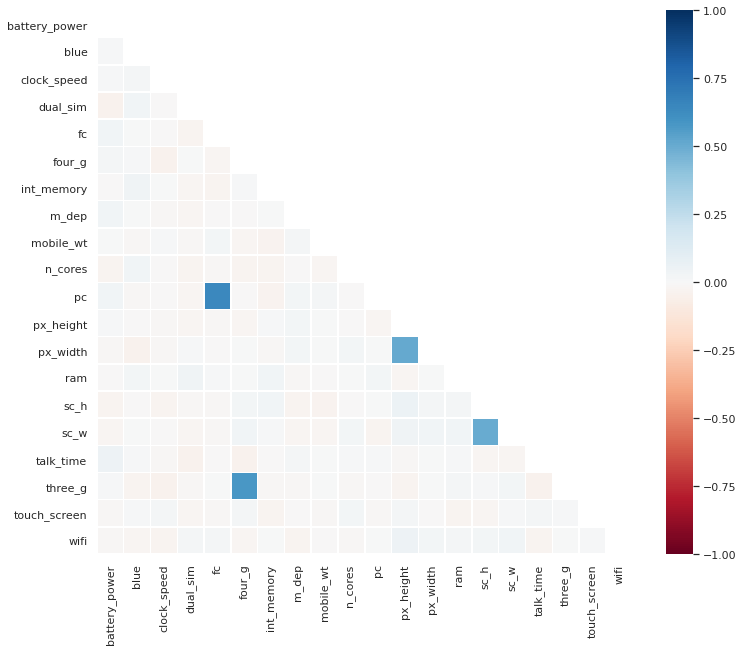

In [ ]:
sns.set_theme(style="white")
plt.figure(figsize=(12,10))
corr = df.drop('price_range', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='RdBu', mask=mask, linewidths=.5, vmin=-1, vmax=1)

In [ ]:
def correlation(dataset, threshold):
  col_corr = set()# Set of all the names of correlated columns
  corr_matrix = df.drop('price_range', axis=1).corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
        colname = corr_matrix.columns[i] # getting the name of column
        col_corr.add(colname)
        return col_corr

In [ ]:
corr_features = correlation(df, 0.85)

In [ ]:
corr_features

No features are highly correlated, of threshold 0.85 and beyond. 

# Chi2 Test for categorical features

A chi-square test is used in statistics to test the independence of two events.

In feature selection, we aim to select the features which are highly dependent on the response.

When two features are independent, the observed count is close to the expected count, thus we will have smaller Chi-Square value. So high Chi-Square value indicates that the hypothesis of independence is incorrect. In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

credit: https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223


In [ ]:
nominal_feature = [feature for feature in df.columns if len(df[feature].unique())<7 and feature != 'price_range']
print("Nominal categorical variables Count: {}".format(len(nominal_feature)))

Nominal categorical variables Count: 6


In [ ]:
nominal_feature

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ordered_rank_features = SelectKBest(score_func=chi2, k=len(nominal_feature))
ordered_features = ordered_rank_features.fit(X[nominal_feature],y)
#we are putting all 20 features in X and see their ranking

In [ ]:
ordered_features.scores_

array([0.72323232, 0.63101079, 1.52157239, 0.32764281, 1.92842942,
       0.42209073])

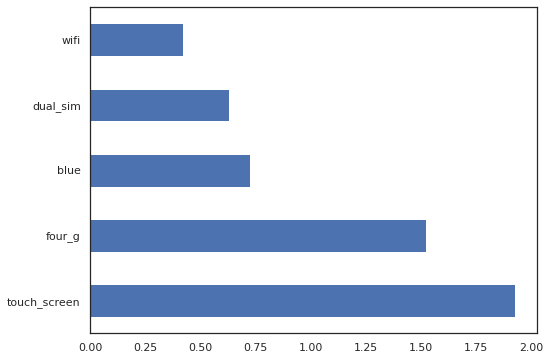

In [ ]:
plt.figure(figsize=(8,6))
feat_importances = pd.Series(ordered_features.scores_, index=nominal_feature)
feat_importances.nlargest().plot(kind='barh')
plt.show()

# ANOVA Test for continuous features

This is a feature selection method for numerical input data when the target variable is categorical.

credit: https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.

ANOVA is used when one variable is numeric and one is categorical, such as numerical input variables and a classification target variable in a classification task.

The results of this test can be used for feature selection where those features that are independent of the target variable can be removed from the dataset.

In [ ]:
cont_feature = []

for i in df.columns:
  if i not in nominal_feature and i != 'price_range':
        cont_feature.append(i)

print("Cont variables Count: {}".format(len(cont_feature)))

Cont variables Count: 14


In [ ]:
cont_feature

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X[cont_feature], y)

anova_rank = pd.Series(fs.scores_)
anova_rank.index = cont_feature
anova_rank_df = pd.DataFrame(anova_rank)
anova_rank_df.reset_index(inplace=True)
anova_rank_df.columns = ['feature','anova_score']
anova_rank_df.sort_values('anova_score', ascending=False, inplace=True)
bottom_3_anova_score = anova_rank_df['feature'].tail(3)

In [ ]:
bottom_3_anova_score

7             pc
2             fc
1    clock_speed
Name: feature, dtype: object

In [ ]:
anova_rank.sort_values(ascending=False)

ram              3520.110824
battery_power      31.598158
px_width           22.620882
px_height          19.484842
mobile_wt           3.594318
int_memory          2.922996
n_cores             2.625415
sc_h                2.225984
sc_w                1.671000
talk_time           1.628811
m_dep               1.500682
pc                  0.825446
fc                  0.772182
clock_speed         0.493708
dtype: float64

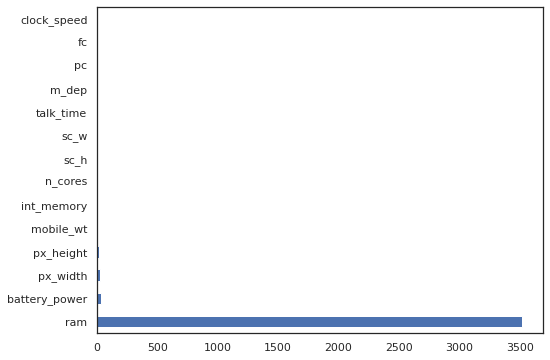

In [ ]:
plt.figure(figsize=(8,6))
anova_rank_importances = pd.Series(fs.scores_, index=cont_feature)
anova_rank_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

Using ANOVA on the continuous features, we can see that below are the few features that are ***independent*** of the target feature. 

pc                  0.825446

fc                  0.772182

clock_speed         0.493708

We can also see the ram has dominantly high dependency of the target feature. This is an important feature which we will keep. 


# Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

feature_importance_score = pd.Series(rf_model.feature_importances_)
feature_importance_score.index = X.columns
feature_importance_score.nlargest(len(feature_importance_score))

ram              0.477915
battery_power    0.075051
px_height        0.058402
px_width         0.055645
mobile_wt        0.040302
int_memory       0.036488
pc               0.030440
sc_w             0.029354
talk_time        0.029258
clock_speed      0.028368
sc_h             0.028047
m_dep            0.025337
fc               0.023803
n_cores          0.022004
dual_sim         0.007372
blue             0.007209
touch_screen     0.006723
wifi             0.006501
four_g           0.006500
three_g          0.005282
dtype: float64

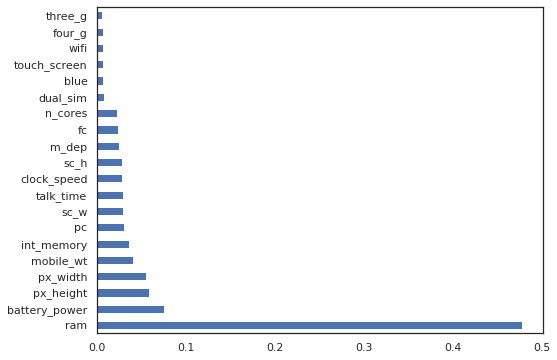

In [ ]:
plt.figure(figsize=(8,6))
feature_importance_score.nlargest(len(feature_importance_score)).plot(kind='barh')
plt.show()

After performing Chi Square, ANOVA, Feature Importance, we can see that few features are most desirable to be used to train our model. 

1. ram
2. battery_power
3. px_width
4. px_height

# Method 1 - Baseline Model (Kitchen sink)

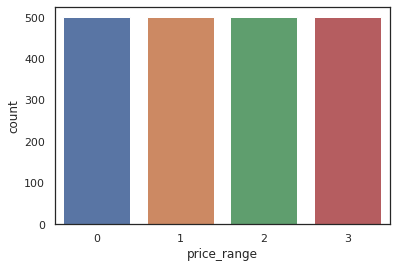

In [ ]:
sns.countplot(df['price_range'])

Target class seems evently distributed, hence we can go with the normal KFold method for our cross validations with 10 splits since dataset is not too huge. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import mean

def run_baseline(X, y, split):
  rf_model = RandomForestClassifier()
  cv = KFold(n_splits=split, random_state=42)
  results = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs = -1, verbose = 10)
  return(mean(results))

In [ ]:
baseline_model_results = run_baseline(X, y, 10)
print("Baseline model accuracy results: ", baseline_model_results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s


Baseline model accuracy results:  0.8855


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


baseline model (kitchen sink method of all features in) accuracy is somewhere short of 0.90. we know we can do better.

# Method 2 - After filtering features manually

We will remove features following features which shows strong independence during ANOVA test.

pc                  0.825446

fc                  0.772182

clock_speed         0.493708

In [ ]:
bottom_3_anova_score.tolist()

['pc', 'fc', 'clock_speed']

In [ ]:
def run_filter(X, y, split):
  X_new = X.drop(bottom_3_anova_score.tolist(), axis=1)
  rf_model = RandomForestClassifier()
  cv = KFold(n_splits=split, random_state=42)
  new_results = cross_val_score(rf_model, X_new, y, scoring='accuracy', cv = cv, n_jobs = -1, verbose=10)
  return(mean(new_results))

In [ ]:
filter_results = run_filter(X, y, 10)
print("new test accuracy dropping 3 features:", filter_results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s


new test accuracy dropping 3 features: 0.8915


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


after removing 3 features, our accuracy is now 0.8915

# Method 3 - ANOVA with gridsearch for K value

Now, let's see if we can remove more features by trying with other K values. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def run_anova_gs(X, y, split):
  cv = KFold(n_splits=split, random_state=42)
  rf_model = RandomForestClassifier()

  anova_s = SelectKBest(score_func = f_classif)
  pipeline = Pipeline(steps=[('anova',anova_s), ('rf', rf_model)])
  grid = dict()
  grid['anova__k'] = [i+1 for i in range(len(X_new.columns))]
  gs_model = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv, verbose=10)
  gs_model.fit(X, y)
  return gs_model

In [ ]:
gs_model = run_anova_gs(X, y, 10)

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

In [ ]:
gs_model.best_params_

{'anova__k': 5}

In [ ]:
gs_model.best_score_

0.921

We are now down to 5 features that yield a better accuracy of 0.917. Which 5 features?

In [ ]:
fs = SelectKBest(score_func=f_classif, k=5)
fs.fit(X, y)
X.columns[fs.get_support()]

Index(['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram'], dtype='object')

# Method 4 - Recursive Feature Elimination - CV

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

As this is a greedy approach by evaluating all the possible combinations of features, it also takes the longest time to implement and execute. 

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import KFold

def run_rfecv(X,y,split):
  rf_model = RandomForestClassifier()
  cv = KFold(n_splits=split, random_state=42)
  rfecv = RFECV(estimator=rf_model, cv=cv, scoring='accuracy', verbose=1)
  rfecv.fit(X, y)
  return rfecv

In [ ]:
rfecv = run_rfecv(X,y,10)

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


In [ ]:
rfecv.grid_scores_

array([0.676 , 0.799 , 0.8705, 0.9175, 0.919 , 0.9155, 0.9065, 0.9025,
       0.9055, 0.903 , 0.8995, 0.8975, 0.892 , 0.8865, 0.8845, 0.8925,
       0.8875, 0.887 , 0.881 , 0.884 ])

In [ ]:
np.max(rfecv.grid_scores_)

0.9190000000000002

In [ ]:
rfecv.n_features_

5

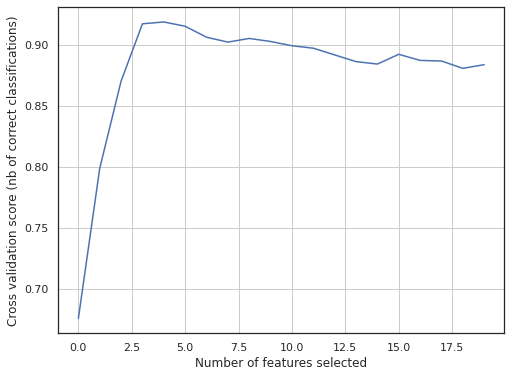

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(0, len(rfecv.grid_scores_)),rfecv.grid_scores_)
plt.grid()
plt.show()

In [ ]:
print("the optimal num of features is", rfecv.n_features_, "with best accuracy of", np.max(rfecv.grid_scores_))

the optimal num of features is 5 with best accuracy of 0.9190000000000002


After RFE, we are down to just 5 features only, with accuracy of close to 0.92

Which 5 features?

In [ ]:
for i in range(X.shape[1]):
	print('{:>14}  {:>10}  {:>12}'.format(X.columns[i], str(rfecv.support_[i]), rfecv.ranking_[i]))

 battery_power        True             1
          blue       False            13
   clock_speed       False             6
      dual_sim       False            14
            fc       False             8
        four_g       False            11
    int_memory       False             2
         m_dep       False             9
     mobile_wt        True             1
       n_cores       False            10
            pc       False             3
     px_height        True             1
      px_width        True             1
           ram        True             1
          sc_h       False             5
          sc_w       False             7
     talk_time       False             4
       three_g       False            16
  touch_screen       False            15
          wifi       False            12


In [ ]:
X.columns[np.where(rfecv.support_ == True)[0]]

Index(['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram'], dtype='object')

In [ ]:
rfecv.estimator_.feature_importances_

array([0.11918713, 0.04540672, 0.08057317, 0.08127357, 0.67355941])

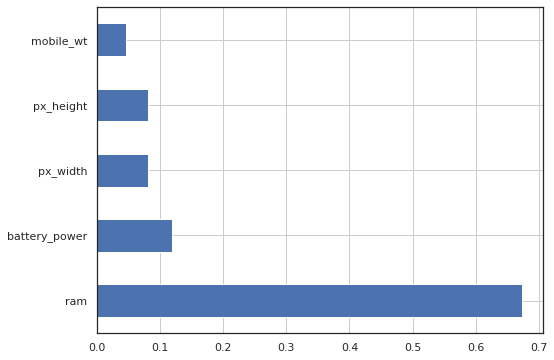

In [ ]:
rfecv_importance_score = pd.Series(rfecv.estimator_.feature_importances_)
rfecv_importance_score.index = X.columns[np.where(rfecv.support_ == True)[0]]

plt.figure(figsize=(8,6))
rfecv_importance_score.nlargest(len(rfecv_importance_score)).plot(kind='barh')
plt.grid()
plt.show()